In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import matplotlib.dates as mdates
from bs4 import BeautifulSoup
import requests
import glob
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [3]:
# # ÌååÏùº Í≤ΩÎ°ú Ìå®ÌÑ¥ ÏÑ§Ï†ï (Ïó¨Í∏∞ÏÑúÎäî forecast_*.csv ÌååÏùºÎßå Í∞ÄÏ†∏Ïò¥)
# file_list = glob.glob('../data/raw/forecast_*.csv')

# # Î™®Îì† ÌååÏùºÏùÑ ÏùΩÏñ¥ÏÑú ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ìï©ÏπòÍ∏∞
# df_list = [pd.read_csv(file, encoding='euc-kr') for file in file_list]
# forecast_df = pd.concat(df_list, ignore_index=True)

# # CSV ÌååÏùºÎ°ú Ï†ÄÏû•
# forecast_df.to_csv('../data/processed/forecast_merged2.csv', index=False)


In [4]:
# ÌååÏùº Í≤ΩÎ°ú ÏÑ§Ï†ï
file_path = '../data/processed/forecast_merged2.csv'
forecast_df = pd.read_csv(file_path)


#ÏùºÏãú Îç∞Ïù¥Ìä∏ÌÉÄÏûÑ Ï†ÅÏö©
forecast_df['ÏùºÏãú'] = pd.to_datetime(forecast_df['ÏùºÏãú'])
forecast_df['Ïó∞ÎèÑ'] = forecast_df['ÏùºÏãú'].dt.year
forecast_df['Ïõî'] = forecast_df['ÏùºÏãú'].dt.month
forecast_df['Ïùº'] = forecast_df['ÏùºÏãú'].dt.day
forecast_df['ÏãúÍ∞Ñ'] = forecast_df['ÏùºÏãú'].dt.hour
forecast_df['ÏöîÏùº'] = forecast_df['ÏùºÏãú'].dt.day_name().str[:3]

# Í≤∞Ï∏°Ïπò Ï†úÍ±∞
forecast_df.fillna(0, inplace=True)

#Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ Ïà´ÏûêÏù∏ÏßÄ ÌôïÏù∏????
numeric_columns = forecast_df.select_dtypes(include=['float64', 'int64']).columns
forecast_df[numeric_columns] = forecast_df[numeric_columns].apply(pd.to_numeric, errors='coerce')


# Í≤∞Í≥º ÌôïÏù∏
forecast_df.head(-5)

ÏßÄÏ†ê                  ÏùºÏãú  ÌíçÏÜç(m/s)  ÌíçÌñ•(deg)  GUSTÌíçÏÜç(m/s)  ÌòÑÏßÄÍ∏∞Ïïï(hPa)  \
0       22105 2020-01-01 00:00:00      6.4    284.0          9.3     1027.5   
1       22105 2020-01-01 01:00:00      6.6    309.0          9.6     1026.7   
2       22105 2020-01-01 02:00:00      7.3    292.0         10.7     1026.6   
3       22105 2020-01-01 03:00:00      7.7    294.0         11.1     1026.6   
4       22105 2020-01-01 04:00:00      7.4    292.0         10.5     1025.9   
...       ...                 ...      ...      ...          ...        ...   
336095  22302 2025-01-12 14:00:00     12.8    308.0         15.6     1016.1   
336096  22302 2025-01-12 15:00:00     12.7    306.0         16.8     1016.2   
336097  22302 2025-01-12 16:00:00     13.9    310.0         16.5     1016.4   
336098  22302 2025-01-12 17:00:00     13.3    300.0         16.5     1016.6   
336099  22302 2025-01-12 18:00:00     15.4    304.0         20.1     1016.8   

        ÏäµÎèÑ(%)  Í∏∞Ïò®(¬∞C)  ÏàòÏò®(¬∞C)  ÏµúÎåÄÌååÍ≥†(m)  Ïú†ÏùòÌååÍ≥†(m)  ÌèâÍ∑†ÌååÍ≥†(m)  ÌååÏ£ºÍ∏∞(sec)  ÌååÌñ•(deg)  \
0        48.0     3.2    14.8      3.5      2.0      1.4       8.0     41.0   
1        44.0     3.0    14.8      3.7      1.9      1.4       8.0     45.0   
2        50.0     3.4    14.8      3.4      2.2      1.6       8.0     43.0   
3        47.0     2.8    14.8      3.2      1.9      1.3       5.8     22.0   
4        54.0     3.1    14.8      3.1      2.0      1.4       8.0     45.0   
...       ...     ...     ...      ...      ...      ...       ...      ...   
336095   71.0     5.0    13.5      4.3      2.3      1.5       7.7    357.0   
336096   70.0     5.3    13.5      3.6      2.2      1.5       6.5    335.0   
336097   71.0     5.4    13.5      3.9      2.4      1.6       7.4    343.0   
336098   70.0     5.6    13.4      4.5      2.6      1.6       8.0    341.0   
336099   78.0     5.3    13.4      5.0      3.2      2.0       8.3    340.0   

          Ïó∞ÎèÑ  Ïõî   Ïùº  ÏãúÍ∞Ñ   ÏöîÏùº  
0       2020  1   1   0  Wed  
1       2020  1   1   1  Wed  
2       2020  1   1   2  Wed  
3       2020  1   1   3  Wed  
4       2020  1   1   4  Wed  
...      ... ..  ..  ..  ...  
336095  2025  1  12  14  Sun  
336096  2025  1  12  15  Sun  
336097  2025  1  12  16  Sun  
336098  2025  1  12  17  Sun  
336099  2025  1  12  18  Sun  

[336100 rows x 19 columns]

In [5]:
# Ïã§ÏãúÍ∞Ñ Ï∂îÍ∞Ä(ÏÖÄÎ†àÎãàÏõÄ?) -- Í∞ïÏÇ¨ÎãòÍªò Ï†úÏßÄÎãπÌï®

# url = 'https://data.kma.go.kr/data/sea/selectBuoyRltmList.do?pgmNo=52'

# # 2Ô∏è‚É£ HTTP ÏöîÏ≤≠ÏùÑ Î≥¥ÎÇ¥ÏÑú Ïõπ ÌéòÏù¥ÏßÄ Í∞ÄÏ†∏Ïò§Í∏∞
# response = requests.get(url)

# # 3Ô∏è‚É£ BeautifulSoupÏùÑ ÏÇ¨Ïö©Ìï¥ HTML ÌååÏã±
# soup = BeautifulSoup(response.text, 'html.parser')

# # 4Ô∏è‚É£ ÏõêÌïòÎäî Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú (Ïòà: Î™®Îì† Ï†úÎ™© ÌÉúÍ∑∏ <h1>)
# titles = soup.find_all('h1')

# # 5Ô∏è‚É£ Ï∂îÏ∂úÌïú Îç∞Ïù¥ÌÑ∞Î•º Ï∂úÎ†•
# for title in titles:
#     print(title.get_text())

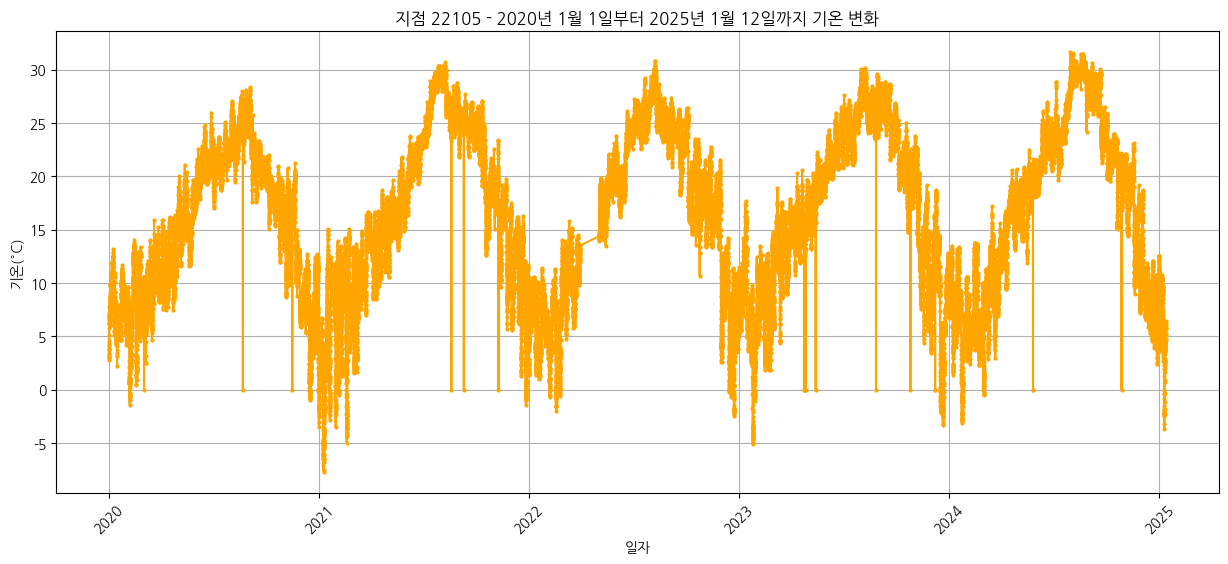

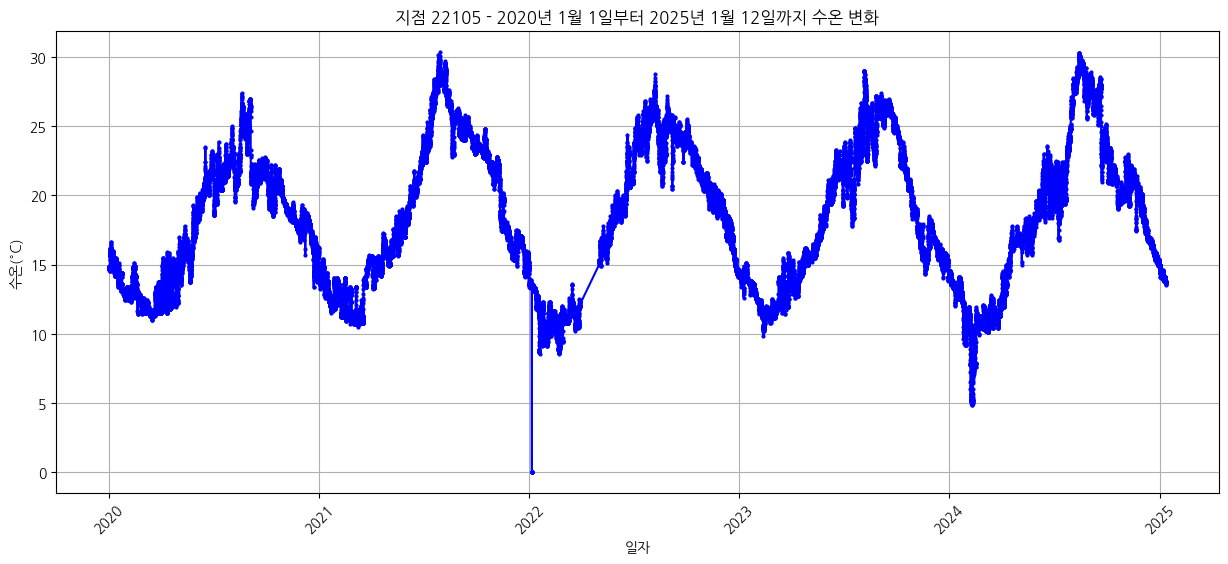

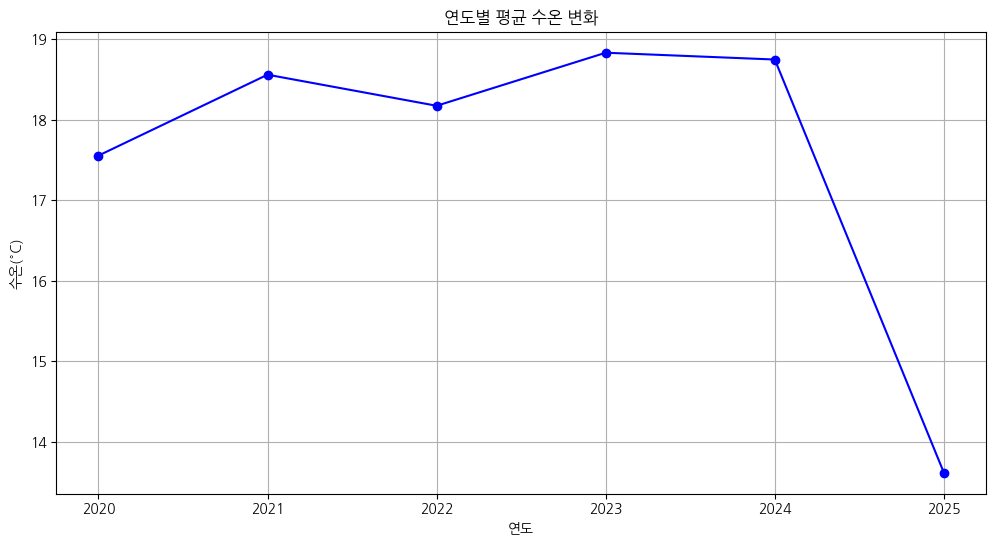

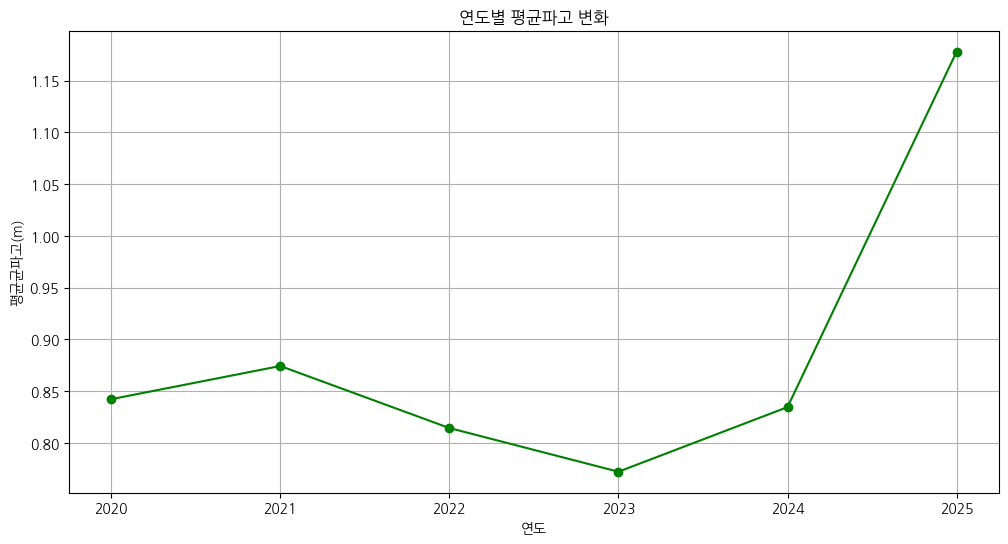

In [6]:
# 1Ô∏è‚É£ ÏßÄÏ†ê 22105 Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ (2020ÎÖÑ 1Ïõî 1ÏùºÎ∂ÄÌÑ∞ 2025ÎÖÑ 1Ïõî 12ÏùºÍπåÏßÄ)
filtered_df = forecast_df[(forecast_df['ÏßÄÏ†ê'] == 22105) & (forecast_df['ÏùºÏãú'] >= '2020-01-01') & (forecast_df['ÏùºÏãú'] <= '2025-01-12')]

# 2Ô∏è‚É£ 'ÏùºÏãú'Î•º Ïù∏Îç±Ïä§Î°ú ÏÑ§Ï†ï
filtered_df.set_index('ÏùºÏãú', inplace=True)

# 3Ô∏è‚É£ Í∏∞Ïò® Î≥ÄÌôî ÏãúÍ∞ÅÌôî
plt.figure(figsize=(15, 6))
plt.plot(filtered_df.index, filtered_df['Í∏∞Ïò®(¬∞C)'], color='orange', linestyle='-', marker='o', markersize=2)
plt.title('ÏßÄÏ†ê 22105 - 2020ÎÖÑ 1Ïõî 1ÏùºÎ∂ÄÌÑ∞ 2025ÎÖÑ 1Ïõî 12ÏùºÍπåÏßÄ Í∏∞Ïò® Î≥ÄÌôî')
plt.xlabel('ÏùºÏûê')
plt.ylabel('Í∏∞Ïò®(¬∞C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# 4Ô∏è‚É£ ÏàòÏò® Î≥ÄÌôî ÏãúÍ∞ÅÌôî
plt.figure(figsize=(15, 6))
plt.plot(filtered_df.index, filtered_df['ÏàòÏò®(¬∞C)'], color='blue', linestyle='-', marker='o', markersize=2)
plt.title('ÏßÄÏ†ê 22105 - 2020ÎÖÑ 1Ïõî 1ÏùºÎ∂ÄÌÑ∞ 2025ÎÖÑ 1Ïõî 12ÏùºÍπåÏßÄ ÏàòÏò® Î≥ÄÌôî')
plt.xlabel('ÏùºÏûê')
plt.ylabel('ÏàòÏò®(¬∞C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(12, 6))
yearly_temp = forecast_df.groupby('Ïó∞ÎèÑ')['ÏàòÏò®(¬∞C)'].mean()
plt.plot(yearly_temp.index, yearly_temp.values, marker='o', color='blue')
plt.title('Ïó∞ÎèÑÎ≥Ñ ÌèâÍ∑† ÏàòÏò® Î≥ÄÌôî')
plt.xlabel('Ïó∞ÎèÑ')
plt.ylabel('ÏàòÏò®(¬∞C)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
hourly_wave = forecast_df.groupby('Ïó∞ÎèÑ')['ÌèâÍ∑†ÌååÍ≥†(m)'].mean()
plt.plot(hourly_wave.index, hourly_wave.values, marker='o', color='green')
plt.title('Ïó∞ÎèÑÎ≥Ñ ÌèâÍ∑†ÌååÍ≥† Î≥ÄÌôî')
plt.xlabel('Ïó∞ÎèÑ')
plt.ylabel('ÌèâÍ∑†Í∑†ÌååÍ≥†(m)')
plt.grid(True)
plt.show()

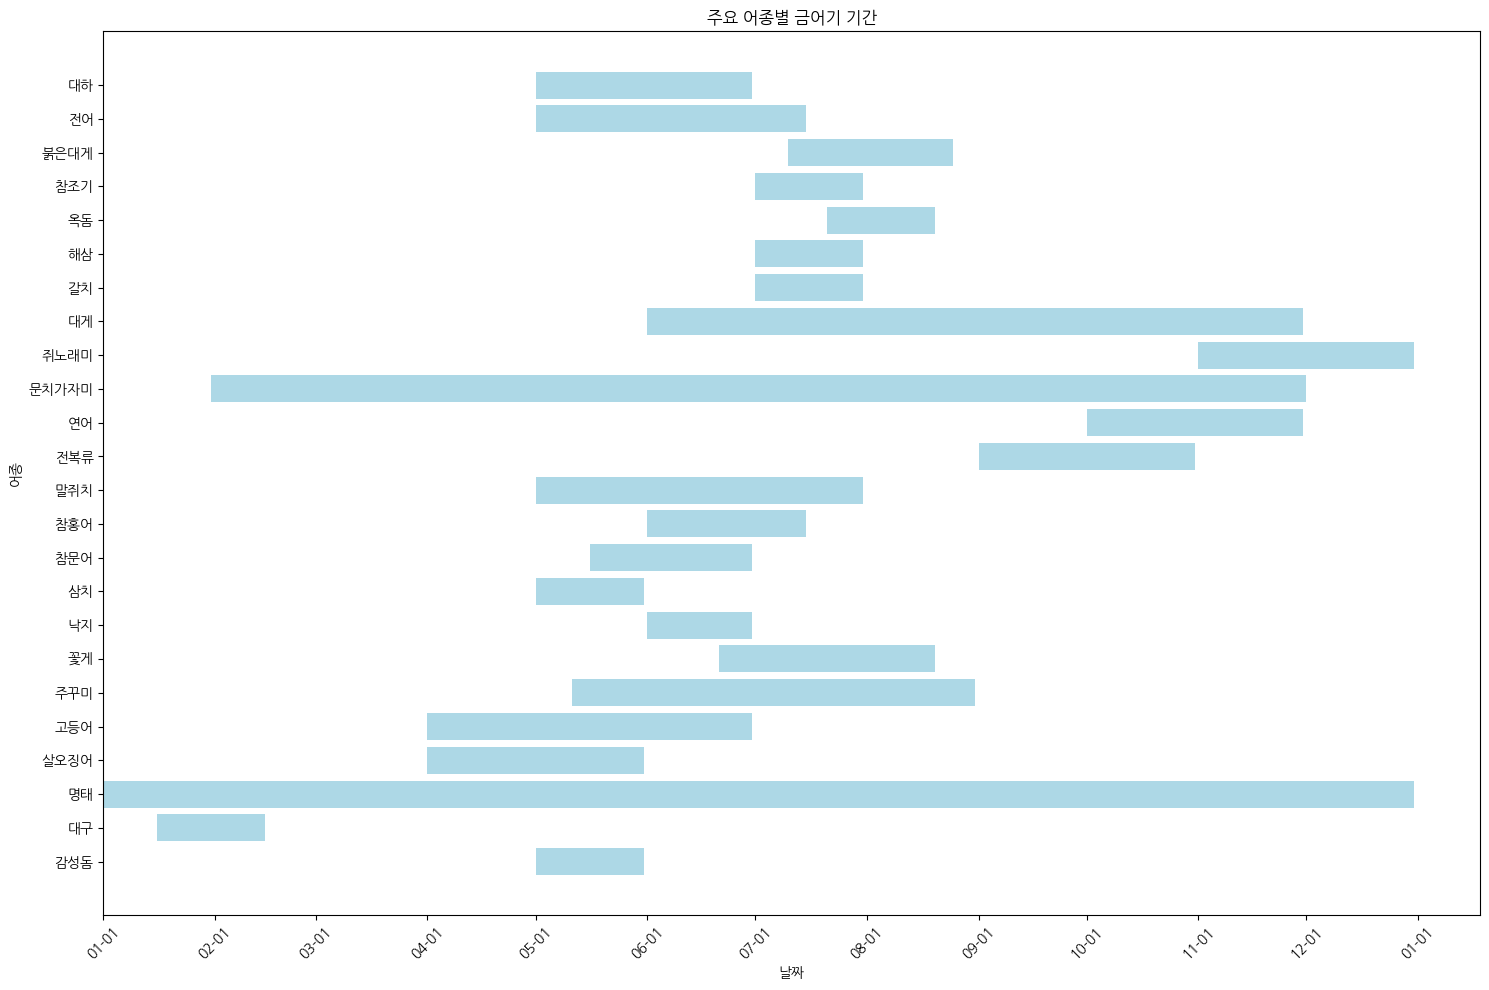

In [9]:
file_path = "../data/raw/Í∏àÏñ¥Í∏∞_Îç∞Ïù¥ÌÑ∞.csv"
df = pd.read_csv(file_path, encoding='utf-8-sig')

# ÎÇ†Ïßú ÌòïÏãù Î≥ÄÌôò
df['Ìè¨ÌöçÍ∏àÏßÄ ÏãúÏûëÏùº'] = pd.to_datetime(df['Ìè¨ÌöçÍ∏àÏßÄ ÏãúÏûëÏùº'], format='%mÏõî %dÏùº')
df['Ìè¨ÌöçÍ∏àÏßÄ Ï¢ÖÎ£åÏùº'] = pd.to_datetime(df['Ìè¨ÌöçÍ∏àÏßÄ Ï¢ÖÎ£åÏùº'], format='%mÏõî %dÏùº')

# Í∏àÏñ¥Í∏∞ Í∏∞Í∞Ñ Í≥ÑÏÇ∞
df['Í∏àÏñ¥Í∏∞ Í∏∞Í∞Ñ'] = df['Ìè¨ÌöçÍ∏àÏßÄ Ï¢ÖÎ£åÏùº'] - df['Ìè¨ÌöçÍ∏àÏßÄ ÏãúÏûëÏùº']

# ÏãúÍ∞ÅÌôî
fig, ax = plt.subplots(figsize=(15, 10))

# Gantt Ï∞®Ìä∏ ÏÉùÏÑ±
for i, row in df.iterrows():
    ax.barh(row['Ïñ¥Ï¢Ö'], row['Í∏àÏñ¥Í∏∞ Í∏∞Í∞Ñ'].days, left=row['Ìè¨ÌöçÍ∏àÏßÄ ÏãúÏûëÏùº'], color='lightblue')

# ÎÇ†Ïßú Ìè¨Îß∑ ÏÑ§Ï†ï
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Í∑∏ÎûòÌîÑ Ï†úÎ™© Î∞è Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title('Ï£ºÏöî Ïñ¥Ï¢ÖÎ≥Ñ Í∏àÏñ¥Í∏∞ Í∏∞Í∞Ñ')
plt.xlabel('ÎÇ†Ïßú')
plt.ylabel('Ïñ¥Ï¢Ö')
plt.tight_layout()
plt.show()

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú ÏÑ§Ï†ï
forecast_file_path = "../data/processed/forecast_merged2.csv"
price_file_path = "../data/raw/ikh_item_price_2025-01-15.csv"

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
forecast_df = pd.read_csv(forecast_file_path)
price_df = pd.read_csv(price_file_path)

# 1. ÎÇ†Ïßú ÌòïÏãù Î≥ÄÌôò
forecast_df['ÏùºÏãú'] = pd.to_datetime(forecast_df['ÏùºÏãú'], errors='coerce')
price_df['priceDate'] = pd.to_datetime(price_df['priceDate'], errors='coerce')

# 2. ÎÇ†Ïßú Í∏∞Ï§ÄÏúºÎ°ú Îëê Îç∞Ïù¥ÌÑ∞ Î≥ëÌï©
merged_df = pd.merge(price_df, forecast_df, left_on='priceDate', right_on='ÏùºÏãú', how='inner')

# 3. Í∏àÏñ¥Í∏∞ Îç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä - Í∞ÄÏÉÅ Í∏àÏñ¥Í∏∞ Ï†ïÎ≥¥
# goldfish_season = {
#     'ÎÜçÏñ¥': ('2022-05-01', '2022-06-30'),
#     'Í¥ëÏñ¥': ('2022-04-01', '2022-05-31'),
#     'ÎåÄÍ≤å': ('2022-07-01', '2022-08-31'),
#     'Ïó∞Ïñ¥': ('2022-09-01', '2022-10-31'),
#     'Ïö∞Îü≠': ('2022-06-01', '2022-07-31'),
#     'Ï∞∏Îèî': ('2022-03-01', '2022-04-30'),
#     'Î∞©Ïñ¥': ('2022-11-01', '2022-12-31')
# }

# Í∏àÏñ¥Í∏∞ Ïª¨Îüº Ï∂îÍ∞Ä
for item, (start, end) in goldfish_season.items():
    merged_df.loc[(merged_df['item'] == item) & (merged_df['priceDate'] >= pd.to_datetime(start)) &
                  (merged_df['priceDate'] <= pd.to_datetime(end)), 'Í∏àÏñ¥Í∏∞'] = True
merged_df['Í∏àÏñ¥Í∏∞'].fillna(False, inplace=True)

# 4. Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns
merged_df[numeric_columns] = merged_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
merged_df.fillna(0, inplace=True)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï∂úÎ†• Ìï®Ïàò (Î°úÏª¨ ÌôòÍ≤ΩÏö©)
def display_dataframe_to_user(name, dataframe):
    print(f"üìä {name}")
    display(dataframe)

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÌôïÏù∏
display_dataframe_to_user(name="Merged Fish Price and Weather Data", dataframe=merged_df)



C:\Users\user\AppData\Local\Temp\ipykernel_13260\4088320752.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Í∏àÏñ¥Í∏∞'].fillna(False, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_13260\4088320752.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['Í∏àÏñ¥Í∏∞'].fillna(False

üìä Merged Fish Price and Weather Data


priceDate  minPrice  avgPrice  maxPrice item       market     ÏßÄÏ†ê  \
0      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22105   
1      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22107   
2      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22186   
3      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22188   
4      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22189   
...           ...       ...       ...       ...  ...          ...    ...   
713206 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22186   
713207 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22188   
713208 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22189   
713209 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22190   
713210 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22297   

               ÏùºÏãú  ÌíçÏÜç(m/s)  ÌíçÌñ•(deg)  ...  ÌòÑÏßÄÍ∏∞Ïïï(hPa)  ÏäµÎèÑ(%)  Í∏∞Ïò®(¬∞C)  ÏàòÏò®(¬∞C)  \
0      2020-01-01      6.4    284.0  ...     1027.5   48.0     3.2    14.8   
1      2020-01-01     11.0    354.0  ...     1032.2   70.0     5.1    17.6   
2      2020-01-01      6.0    326.0  ...     1034.2   56.0     1.7    11.1   
3      2020-01-01      5.2    348.0  ...     1030.7   42.0     2.3    11.6   
4      2020-01-01      7.6    317.0  ...        0.0   47.0     3.8    17.5   
...           ...      ...      ...  ...        ...    ...     ...     ...   
713206 2020-12-25     10.7    323.0  ...     1024.5   53.0     6.3    11.2   
713207 2020-12-25     12.1    322.0  ...     1018.8   52.0     6.3    13.0   
713208 2020-12-25      8.9    338.0  ...     1017.0   52.0     7.2    17.5   
713209 2020-12-25      9.2    287.0  ...     1016.5   47.0     7.6    14.4   
713210 2020-12-25     11.0    335.0  ...     1024.5   46.0     7.7    14.0   

        ÏµúÎåÄÌååÍ≥†(m)  Ïú†ÏùòÌååÍ≥†(m)  ÌèâÍ∑†ÌååÍ≥†(m)  ÌååÏ£ºÍ∏∞(sec)  ÌååÌñ•(deg)    Í∏àÏñ¥Í∏∞  
0           3.5      2.0      1.4       8.0     41.0  False  
1           3.2      2.0      1.4       8.0    357.0  False  
2           2.8      1.6      1.2       6.4    333.0  False  
3           1.5      0.8      0.6       3.4    298.0  False  
4           4.4      3.0      2.1      10.7     36.0  False  
...         ...      ...      ...       ...      ...    ...  
713206      3.0      2.2      1.5       6.4    316.0  False  
713207      2.1      1.5      1.0       4.6    297.0  False  
713208      2.2      1.4      1.0       4.3    345.0  False  
713209      3.3      1.9      1.4       6.4    359.0  False  
713210      2.8      1.8      1.3       6.4    329.0  False  

[713211 rows x 21 columns]

AttributeError: 'NoneType' object has no attribute 'info'

In [ ]:
# ÌååÏùº Í≤ΩÎ°ú ÏÑ§Ï†ï
redtide_path = '../data/raw/Ï†ÅÏ°∞Îç∞Ïù¥ÌÑ∞.csv'
redtide_df = pd.read_csv(redtide_path)

# 1. ÎÇ†Ïßú ÌòïÏãù Î≥ÄÌôò
redtide_df['ÏòàÏ∞∞ÏùºÏûê'] = pd.to_datetime(redtide_df['ÏòàÏ∞∞ÏùºÏûê'], errors='coerce')

# 2. Î∞úÏÉùÌï¥Ïó≠ Î≤îÏ£ºÌôî
region_mapping = {
    'Ï†ÑÎÇ®': 1, 'Ïö∏ÏÇ∞': 2, 'Í≤ΩÎÇ®': 3, 'Î∂ÄÏÇ∞': 4, 'Ï†úÏ£º': 5
}

redtide_df['Î∞úÏÉùÌï¥Ïó≠_Î≤îÏ£º'] = redtide_df['Î∞úÏÉùÌï¥Ïó≠'].apply(lambda x: next((v for k, v in region_mapping.items() if k in str(x)), 0))

# 3. Ï†ÅÏ°∞ÏÉùÎ¨º Î≤îÏ£ºÌôî
species_list = [
    'Cochlodinium polykrikoides', 'Noctiluca sp.', 'Mesodinium rubrum',
    'Ceratium furca', 'Akashiwo sanguinea', 'Heterosigma akashiwo', 'Skeletonema'
]

redtide_df['Ï†ÅÏ°∞ÏÉùÎ¨º_Î≤îÏ£º'] = redtide_df['Ï†ÅÏ°∞ÏÉùÎ¨º'].apply(lambda x: x if x in species_list else 'Í∏∞ÌÉÄ')

# 4. Î∞ÄÎèÑ, ÏàòÏò®, ÏóºÎ∂Ñ Ï§ëÍ∞ÑÍ∞í Ï≤òÎ¶¨
def calculate_mid_value(range_str):
    try:
        start, end = map(float, range_str.split('~'))
        return (start + end) / 2
    except:
        return None

redtide_df['Î∞ÄÎèÑ(Í∞úÏ≤¥Ïàò/mL)'] = redtide_df['Î∞ÄÎèÑ(Í∞úÏ≤¥Ïàò/mL)'].apply(calculate_mid_value)
redtide_df['ÏàòÏò®(C)'] = redtide_df['ÏàòÏò®(C)'].apply(calculate_mid_value)
redtide_df['ÏóºÎ∂Ñ'] = redtide_df['ÏóºÎ∂Ñ'].apply(calculate_mid_value)

# 5. ÎÇ†Ïßú Í∏∞Ï§Ä Î≥ëÌï©
combined_df = pd.merge(merged_df, redtide_df, left_on='priceDate', right_on='ÏòàÏ∞∞ÏùºÏûê', how='left')

# 6. Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
combined_df.fillna(0, inplace=True)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï∂úÎ†• Ìï®Ïàò
def display_dataframe_to_user(name, dataframe):
    print(f"üìä {name}")
    display(dataframe)

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÌôïÏù∏
display_dataframe_to_user(name="Combined DataFrame", dataframe=combined_df)

# Í∏àÏñ¥Í∏∞ Ïª¨Îüº Ï†úÍ±∞
combined_df.drop(columns=['Í∏àÏñ¥Í∏∞'], inplace=True)

# # Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ CSV ÌååÏùºÎ°ú Ï†ÄÏû•
# output_path = '../data/raw/combined_data.csv'
# combined_df.to_csv(output_path, index=False, encoding='utf-8-sig')

# print(f"‚úÖ Í∏àÏñ¥Í∏∞ Ïª¨ÎüºÏùÑ Ï†úÍ±∞Ìïú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏù¥ {output_path} Í≤ΩÎ°úÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")

C:\Users\user\AppData\Local\Temp\ipykernel_13260\1932869694.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  combined_df.fillna(0, inplace=True)


üìä Combined DataFrame


priceDate  minPrice  avgPrice  maxPrice item       market     ÏßÄÏ†ê  \
0      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22105   
1      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22107   
2      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22186   
3      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22188   
4      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22189   
...           ...       ...       ...       ...  ...          ...    ...   
806596 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22186   
806597 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22188   
806598 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22189   
806599 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22190   
806600 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22297   

               ÏùºÏãú  ÌíçÏÜç(m/s)  ÌíçÌñ•(deg)  ...    Í∏àÏñ¥Í∏∞  ÏòàÏ∞∞ÏùºÏûê  Î∞úÏÉùÌï¥Ïó≠  Ï†ÅÏ°∞ÏÉùÎ¨º  Î∞ÄÎèÑ(Í∞úÏ≤¥Ïàò/mL)  \
0      2020-01-01      6.4    284.0  ...  False     0     0     0         0.0   
1      2020-01-01     11.0    354.0  ...  False     0     0     0         0.0   
2      2020-01-01      6.0    326.0  ...  False     0     0     0         0.0   
3      2020-01-01      5.2    348.0  ...  False     0     0     0         0.0   
4      2020-01-01      7.6    317.0  ...  False     0     0     0         0.0   
...           ...      ...      ...  ...    ...   ...   ...   ...         ...   
806596 2020-12-25     10.7    323.0  ...  False     0     0     0         0.0   
806597 2020-12-25     12.1    322.0  ...  False     0     0     0         0.0   
806598 2020-12-25      8.9    338.0  ...  False     0     0     0         0.0   
806599 2020-12-25      9.2    287.0  ...  False     0     0     0         0.0   
806600 2020-12-25     11.0    335.0  ...  False     0     0     0         0.0   

        ÏàòÏò®(C)   ÏóºÎ∂Ñ  Ï¢åÌëú  Î∞úÏÉùÌï¥Ïó≠_Î≤îÏ£º  Ï†ÅÏ°∞ÏÉùÎ¨º_Î≤îÏ£º  
0         0.0  0.0   0      0.0        0  
1         0.0  0.0   0      0.0        0  
2         0.0  0.0   0      0.0        0  
3         0.0  0.0   0      0.0        0  
4         0.0  0.0   0      0.0        0  
...       ...  ...  ..      ...      ...  
806596    0.0  0.0   0      0.0        0  
806597    0.0  0.0   0      0.0        0  
806598    0.0  0.0   0      0.0        0  
806599    0.0  0.0   0      0.0        0  
806600    0.0  0.0   0      0.0        0  

[806601 rows x 30 columns]

‚úÖ Í∏àÏñ¥Í∏∞ Ïª¨ÎüºÏùÑ Ï†úÍ±∞Ìïú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏù¥ ../data/raw/combined_data.csv Í≤ΩÎ°úÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.


In [ ]:
main_Data = '../data/raw/combined_data.csv'
main_df = pd.read_csv(main_Data)
# main_df.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806601 entries, 0 to 806600
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ÌååÌñ•(deg)     806601 non-null  int64  
 1   ÏòàÏ∞∞ÏùºÏûê        806601 non-null  object 
 2   Î∞úÏÉùÌï¥Ïó≠        806601 non-null  object 
 3   Ï†ÅÏ°∞ÏÉùÎ¨º        806601 non-null  object 
 4   Î∞ÄÎèÑ(Í∞úÏ≤¥Ïàò/mL)  806601 non-null  float64
 5   ÏàòÏò®(C).1     806601 non-null  float64
 6   ÏóºÎ∂Ñ          806601 non-null  float64
 7   Ï¢åÌëú          806601 non-null  object 
 8   Î∞úÏÉùÌï¥Ïó≠_Î≤îÏ£º     806601 non-null  int64  
 9   Ï†ÅÏ°∞ÏÉùÎ¨º_Î≤îÏ£º     806601 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 61.5+ MB
None


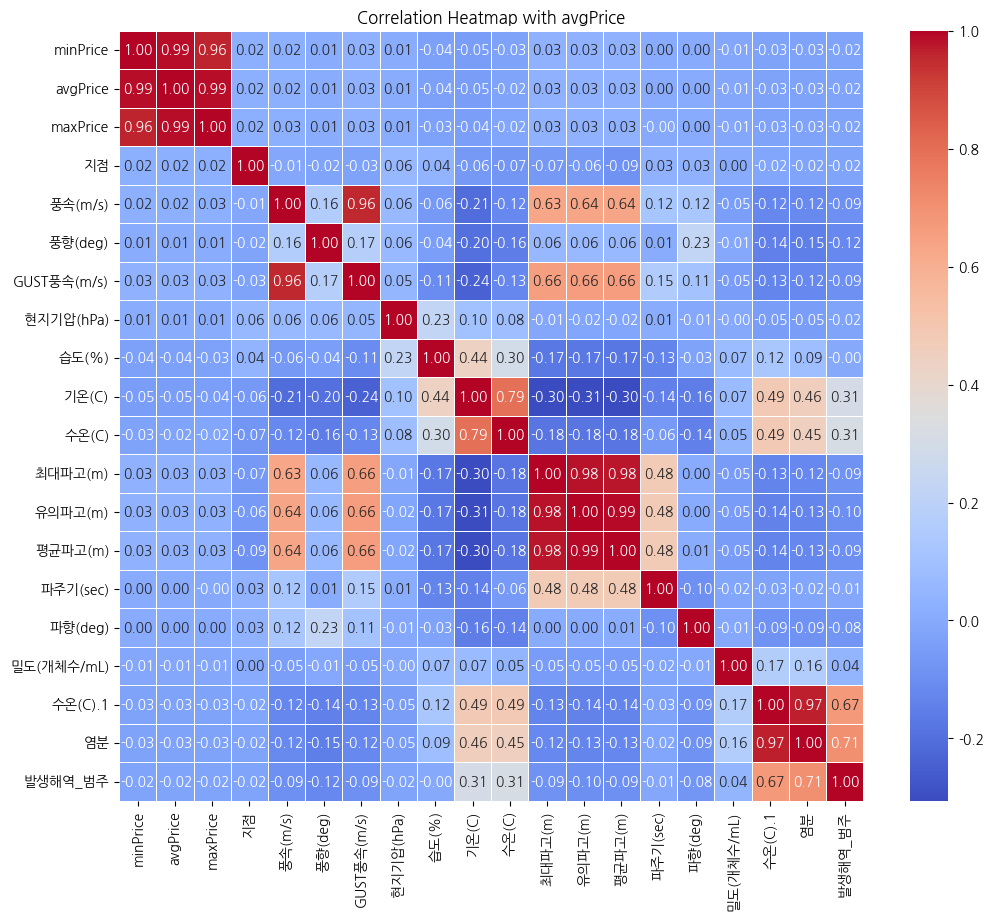

Mean Squared Error: 561415.85


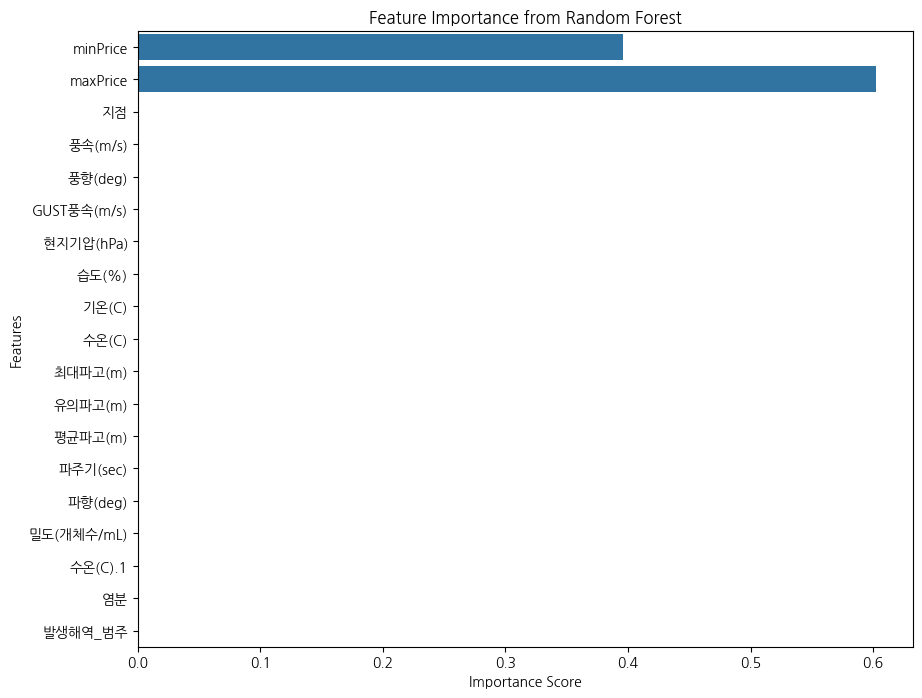

In [31]:
# ÌååÏùº Î∂àÎü¨Ïò§Í∏∞
main_Data = '../data/raw/combined_data.csv'
main_df = pd.read_csv(main_Data)

# ‚úÖ Ïà´ÏûêÌòï Îç∞Ïù¥ÌÑ∞Îßå Ï∂îÏ∂ú (Î¨∏ÏûêÏó¥ Î∞è ÎÇ†Ïßú Ïó¥ Ï†úÍ±∞)
numeric_df = main_df.select_dtypes(include=['float64', 'int64'])

# ‚úÖ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ ÏÉùÏÑ±
plt.figure(figsize=(12, 10))
corr = numeric_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap with avgPrice")
plt.show()

# ‚úÖ ÎûúÎç§ Ìè¨Î†àÏä§Ìä∏ Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìï¥ Ï§ëÏöî Î≥ÄÏàò Ï∞æÍ∏∞
# X: avgPriceÎ•º Ï†úÏô∏Ìïú Ïà´ÏûêÌòï Ïó¥, y: avgPrice
X = numeric_df.drop(columns=['avgPrice'])
y = main_df['avgPrice']

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Î™®Îç∏ ÌïôÏäµ
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# ÏòàÏ∏° Î∞è ÌèâÍ∞Ä
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# ‚úÖ Î≥ÄÏàò Ï§ëÏöîÎèÑ ÏãúÍ∞ÅÌôî
importance = rf.feature_importances_
features = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=importance, y=features)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


In [ ]:


# Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú ÏÑ§Ï†ï
forecast_file_path = "../data/processed/forecast_merged2.csv"
price_file_path = "../data/raw/ikh_item_price_2025-01-15.csv"

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
forecast_df = pd.read_csv(forecast_file_path)
price_df = pd.read_csv(price_file_path)

# 1. ÎÇ†Ïßú ÌòïÏãù Î≥ÄÌôò
forecast_df['ÏùºÏãú'] = pd.to_datetime(forecast_df['ÏùºÏãú'], errors='coerce')
price_df['priceDate'] = pd.to_datetime(price_df['priceDate'], errors='coerce')

# 2. ÎÇ†Ïßú Í∏∞Ï§ÄÏúºÎ°ú Îëê Îç∞Ïù¥ÌÑ∞ Î≥ëÌï©
merged_df = pd.merge(price_df, forecast_df, left_on='priceDate', right_on='ÏùºÏãú', how='inner')

# 3. Í∏àÏñ¥Í∏∞ Îç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä - Í∞ÄÏÉÅ Í∏àÏñ¥Í∏∞ Ï†ïÎ≥¥
goldfish_season = {
    'ÎÜçÏñ¥': ('2022-05-01', '2022-06-30'),
    'Í¥ëÏñ¥': ('2022-04-01', '2022-05-31'),
    'ÎåÄÍ≤å': ('2022-07-01', '2022-08-31'),
    'Ïó∞Ïñ¥': ('2022-09-01', '2022-10-31'),
    'Ïö∞Îü≠': ('2022-06-01', '2022-07-31'),
    'Ï∞∏Îèî': ('2022-03-01', '2022-04-30'),
    'Î∞©Ïñ¥': ('2022-11-01', '2022-12-31')
}

# Í∏àÏñ¥Í∏∞ Ïª¨Îüº Ï∂îÍ∞Ä
for item, (start, end) in goldfish_season.items():
    merged_df.loc[(merged_df['item'] == item) & (merged_df['priceDate'] >= pd.to_datetime(start)) &
                  (merged_df['priceDate'] <= pd.to_datetime(end)), 'Í∏àÏñ¥Í∏∞'] = True
merged_df['Í∏àÏñ¥Í∏∞'].fillna(False, inplace=True)

# 4. Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns
merged_df[numeric_columns] = merged_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
merged_df.fillna(0, inplace=True)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï∂úÎ†• Ìï®Ïàò (Î°úÏª¨ ÌôòÍ≤ΩÏö©)
def display_dataframe_to_user(name, dataframe):
    print(f"üìä {name}")
    display(dataframe)

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÌôïÏù∏
display_dataframe_to_user(name="Merged Fish Price and Weather Data", dataframe=merged_df)

C:\Users\user\AppData\Local\Temp\ipykernel_114492\2053734358.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Í∏àÏñ¥Í∏∞'].fillna(False, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_114492\2053734358.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['Í∏àÏñ¥Í∏∞'].fillna(Fal

üìä Merged Fish Price and Weather Data


priceDate  minPrice  avgPrice  maxPrice item       market     ÏßÄÏ†ê  \
0      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22105   
1      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22107   
2      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22186   
3      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22188   
4      2020-01-01     25000     28130     30000   ÎÜçÏñ¥       ÎÖ∏ÎüâÏßÑ 1Ï∏µ  22189   
...           ...       ...       ...       ...  ...          ...    ...   
713206 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22186   
713207 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22188   
713208 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22189   
713209 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22190   
713210 2020-12-25     30000     30000     30000   Î∞©Ïñ¥  Î∂ÄÏÇ∞ÎØºÎùΩÏñ¥ÎØºÌôúÏñ¥ÏßÅÌåêÏû•  22297   

               ÏùºÏãú  ÌíçÏÜç(m/s)  ÌíçÌñ•(deg)  ...  ÌòÑÏßÄÍ∏∞Ïïï(hPa)  ÏäµÎèÑ(%)  Í∏∞Ïò®(¬∞C)  ÏàòÏò®(¬∞C)  \
0      2020-01-01      6.4    284.0  ...     1027.5   48.0     3.2    14.8   
1      2020-01-01     11.0    354.0  ...     1032.2   70.0     5.1    17.6   
2      2020-01-01      6.0    326.0  ...     1034.2   56.0     1.7    11.1   
3      2020-01-01      5.2    348.0  ...     1030.7   42.0     2.3    11.6   
4      2020-01-01      7.6    317.0  ...        0.0   47.0     3.8    17.5   
...           ...      ...      ...  ...        ...    ...     ...     ...   
713206 2020-12-25     10.7    323.0  ...     1024.5   53.0     6.3    11.2   
713207 2020-12-25     12.1    322.0  ...     1018.8   52.0     6.3    13.0   
713208 2020-12-25      8.9    338.0  ...     1017.0   52.0     7.2    17.5   
713209 2020-12-25      9.2    287.0  ...     1016.5   47.0     7.6    14.4   
713210 2020-12-25     11.0    335.0  ...     1024.5   46.0     7.7    14.0   

        ÏµúÎåÄÌååÍ≥†(m)  Ïú†ÏùòÌååÍ≥†(m)  ÌèâÍ∑†ÌååÍ≥†(m)  ÌååÏ£ºÍ∏∞(sec)  ÌååÌñ•(deg)    Í∏àÏñ¥Í∏∞  
0           3.5      2.0      1.4       8.0     41.0  False  
1           3.2      2.0      1.4       8.0    357.0  False  
2           2.8      1.6      1.2       6.4    333.0  False  
3           1.5      0.8      0.6       3.4    298.0  False  
4           4.4      3.0      2.1      10.7     36.0  False  
...         ...      ...      ...       ...      ...    ...  
713206      3.0      2.2      1.5       6.4    316.0  False  
713207      2.1      1.5      1.0       4.6    297.0  False  
713208      2.2      1.4      1.0       4.3    345.0  False  
713209      3.3      1.9      1.4       6.4    359.0  False  
713210      2.8      1.8      1.3       6.4    329.0  False  

[713211 rows x 21 columns]

### Ïù¥Ìïò Ìï¥ÏñëÌôòÍ≤ΩÏ∏°Ï†ïÎßù(Ïö©Ï°¥ÏÇ∞ÏÜåÎüâ)

In [7]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import sys
import os
current_dir = os.getcwd()
sys.path.append(current_dir)  # Î£®Ìä∏ ÎîîÎ†âÌÑ∞Î¶¨ Í≤ΩÎ°ú Ï∂îÍ∞Ä  # .py
sys.path.append(os.path.dirname(current_dir))  # ÏÉÅÏúÑ ÎîîÎ†âÌÑ∞Î¶¨ Í≤ΩÎ°ú Ï∂îÍ∞Ä  # .ipynb
from configs.API import api_key


In [ ]:
# API ÏóîÎìúÌè¨Ïù∏Ìä∏ Î∞è Ïù∏Ï¶ùÌÇ§ ÏÑ§Ï†ï
endpoint = "http://apis.data.go.kr/B553931/service/OceansNemoService2"

# ÏöîÏ≤≠ ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
params = {
    "serviceKey": api_key,         # ÌïÑÏàò: Ïù∏Ï¶ùÌÇ§ (DecodingÎêú ÌÇ§ ÏÇ¨Ïö©)
    "numOfRows": 100,              # ÏÑ†ÌÉù: Ìïú ÌéòÏù¥ÏßÄÏóê Î™á Í∞úÏùò Í≤∞Í≥ºÎ•º Î∞õÏùÑÏßÄ ÏÑ§Ï†ï
    "pageNo": 1,                   # ÏÑ†ÌÉù: ÌéòÏù¥ÏßÄ Î≤àÌò∏ (Í∏∞Î≥∏Í∞íÏùÄ 1)
    "resultType": "xml",           # ÏÑ†ÌÉù: Í≤∞Í≥º ÌòïÏãù (xml ÎòêÎäî json Ï§ë ÏÑ†ÌÉù Í∞ÄÎä•)
}

response = requests.get(
    url="http://apis.data.go.kr/B553931/service/OceansNemoService2/getOceansNemo2",
    params={
        'ServiceKey': api_key
    }
)

# API Ìò∏Ï∂ú
# response = requests.get(endpoint, params=params)

# ÏùëÎãµ ÌôïÏù∏ Î∞è Ï∂úÎ†•
if response.status_code == 200:
    print("API Ìò∏Ï∂ú ÏÑ±Í≥µ")
    print(response.text)  # XML ÎòêÎäî JSON ÌòïÌÉúÏùò Í≤∞Í≥º Ï∂úÎ†•
else:
    print(f"API Ìò∏Ï∂ú Ïã§Ìå®. ÏÉÅÌÉú ÏΩîÎìú: {response.status_code}")